In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, accuracy_score, recall_score, \
    ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Prediction with random Forest
The Data needs to be updated, so for testing, I used a subset of the data with no missing values

In [3]:
X_train = read_csv('data/X_train.csv')
y_train = read_csv('data/y_train.csv').values.ravel()
X_test = read_csv('data/X_test.csv')
y_test = read_csv('data/y_test.csv').values.ravel()

X_train_alt = read_csv('data/X_train_alt.csv')
y_train_alt = read_csv('data/y_train_alt.csv').values.ravel()
X_test_alt = read_csv('data/X_test_alt.csv')
y_test_alt = read_csv('data/y_test_alt.csv').values.ravel()

### Random Forest Pipline

### Random Forest classification pipeline with hyperparameter optimization

This section builds a preprocessing + RandomForest pipeline, performs hyperparameter optimization with cross-validated grid search on `X_train, y_train`, and evaluates the best model on the test set.

In [6]:
categorical_features = ['ForagingGround', 'Species', 'CalendarWeek']
numeric_features = ['CCL_cm', 'CCW_cm', 'Weight_Kg']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf_clf)
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 20, 30],
    'rf__min_samples_split': [2, 3, 5],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__criterion': ['gini'],              # 'entropy'
    'rf__max_features': ['sqrt']            # 'log2'
}

rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [7]:
rf_grid_search.fit(X_train, y_train)

rf_best_model = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


ValueError: 
All the 540 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3652, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'ForagingGround'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3654, in get_loc
    raise KeyError(key) from err
KeyError: 'ForagingGround'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [17]:
rf_grid_search.fit(X_train, y_train_alt)

rf_best_model_alt = rf_grid_search.best_estimator_
rf_best_params_alt = rf_grid_search.best_params_
rf_best_score_alt = rf_grid_search.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


### Evaluation of the optimized Random Forest on the test set

In [16]:
y_pred = rf_best_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, y_pred)
rf_test_f1_macro = f1_score(y_test, y_pred, average='macro')
rf_test_recall_macro = recall_score(y_test, y_pred, average='macro')
rf_cm = confusion_matrix(y_test, y_pred)

rf_test_accuracy, rf_test_f1_macro, rf_test_recall_macro

(0.3187280458495101, 0.12076765195390035, 0.12758932161979564)

In [18]:
y_pred_alt = rf_best_model_alt.predict(X_test)

rf_test_accuracy_alt = accuracy_score(y_test_alt, y_pred_alt)
rf_test_f1_macro_alt = f1_score(y_test_alt, y_pred_alt, average='macro')
rf_test_recall_macro_alt = recall_score(y_test_alt, y_pred_alt, average='macro')
rf_cm_alt = confusion_matrix(y_test_alt, y_pred_alt)

rf_test_accuracy_alt, rf_test_f1_macro_alt, rf_test_recall_macro_alt

(0.6821963394342762, 0.4171655953290986, 0.43053435601986695)

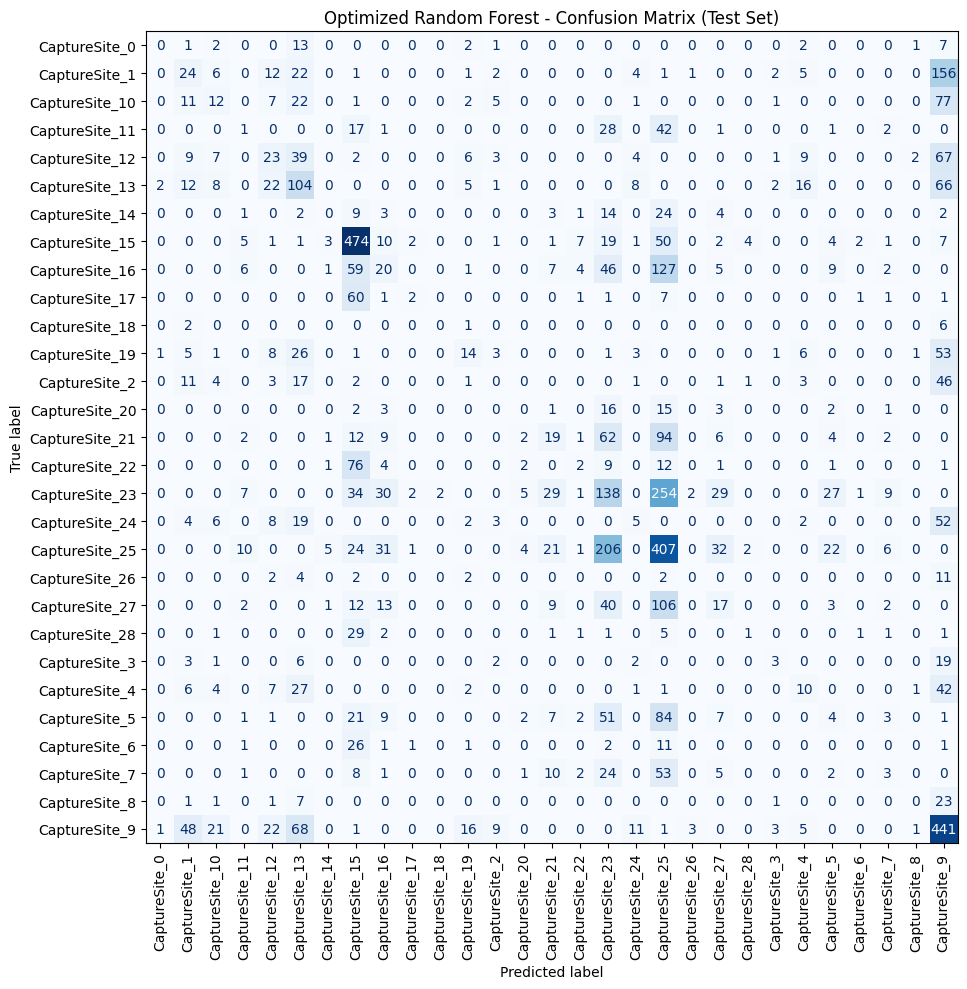

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_best_model.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

In [1]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_alt, display_labels=rf_best_model_alt.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

### Best hyperparameters and cross-validated training score

In [21]:
rf_best_params, rf_best_score


({'rf__criterion': 'gini',
  'rf__max_depth': 30,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 100},
 0.11398109015675814)

In [22]:
rf_best_params_alt, rf_best_score_alt

({'rf__criterion': 'gini',
  'rf__max_depth': 30,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 300},
 0.4207081489158361)

### Feature importance of the optimized Random Forest

The following cells extract and display the feature importances of the best Random Forest model, including the one-hot encoded categorical features.

In [ ]:
rf_feature_importances_df = pd.DataFrame(
    {'feature': feature_names, 'importance': rf_feature_importances}
).sort_values('importance', ascending=False)

rf_feature_importances_df

In [23]:
preprocess_best = rf_best_model.named_steps['preprocess']
rf_best = rf_best_model.named_steps['rf']

cat_encoder = preprocess_best.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_feature_names, np.array(numeric_features)])

rf_feature_importances = rf_best.feature_importances_

rf_feature_importances_df = pd.DataFrame(
    {'feature': feature_names, 'importance': rf_feature_importances}
).sort_values('importance', ascending=False)

rf_feature_importances_df

KeyError: 'preprocess'

In [28]:
preprocess_best_alt = rf_best_model_alt.named_steps['preprocess']
rf_best_alt = rf_best_model_alt.named_steps['rf']

cat_encoder_alt = preprocess_best_alt.named_transformers_['cat']
cat_feature_names_alt = cat_encoder_alt.get_feature_names_out(categorical_features)
feature_names_alt = np.concatenate([cat_feature_names_alt, np.array(numeric_features)])

rf_feature_importances_alt = rf_best_alt.feature_importances_

rf_feature_importances_df_alt = pd.DataFrame(
    {'feature': feature_names_alt, 'importance': rf_feature_importances_alt}
).sort_values('importance', ascending=False)

rf_feature_importances_df_alt

,feature,importance
0,ForagingGround_Creek,0.273902
1,ForagingGround_Ocean,0.200670
64,Weight_Kg,0.116940
62,CCL_cm,0.116057
63,CCW_cm,0.115965
...,...,...
8,Species_Species_7,0.000318
61,CalendarWeek_52,0.000298
3,Species_Species_1,0.000023
4,Species_Species_2,0.000009


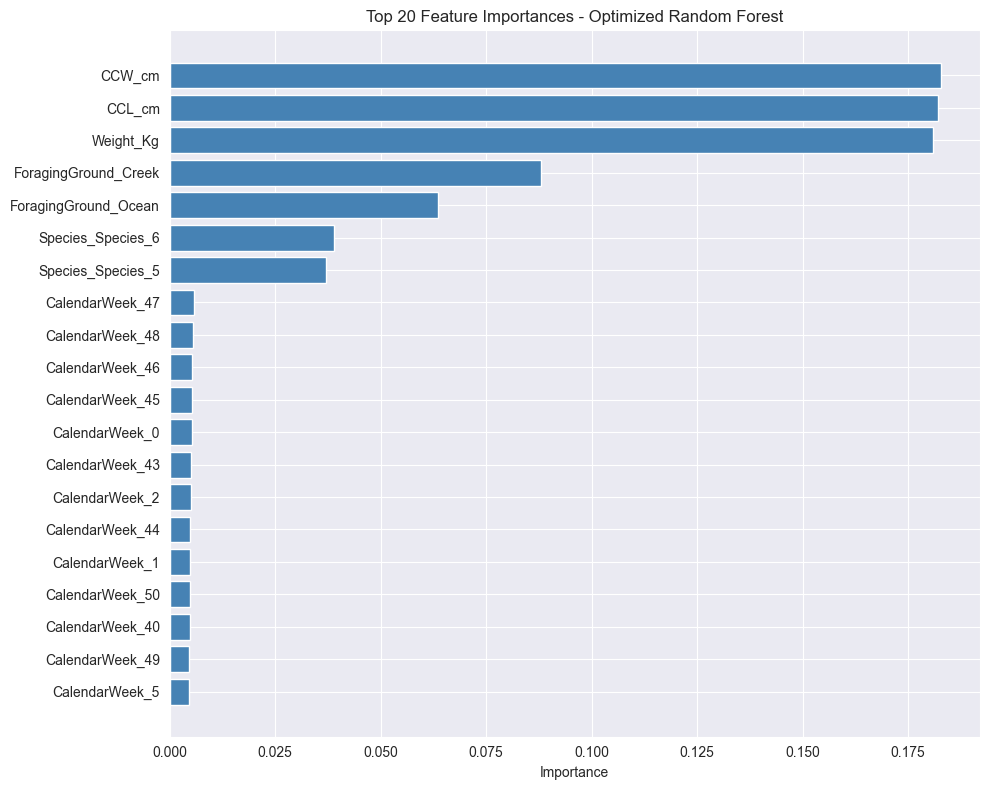

In [20]:
top_n = 20
top_features = rf_feature_importances_df.head(top_n).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Optimized Random Forest')
plt.tight_layout()
plt.show()


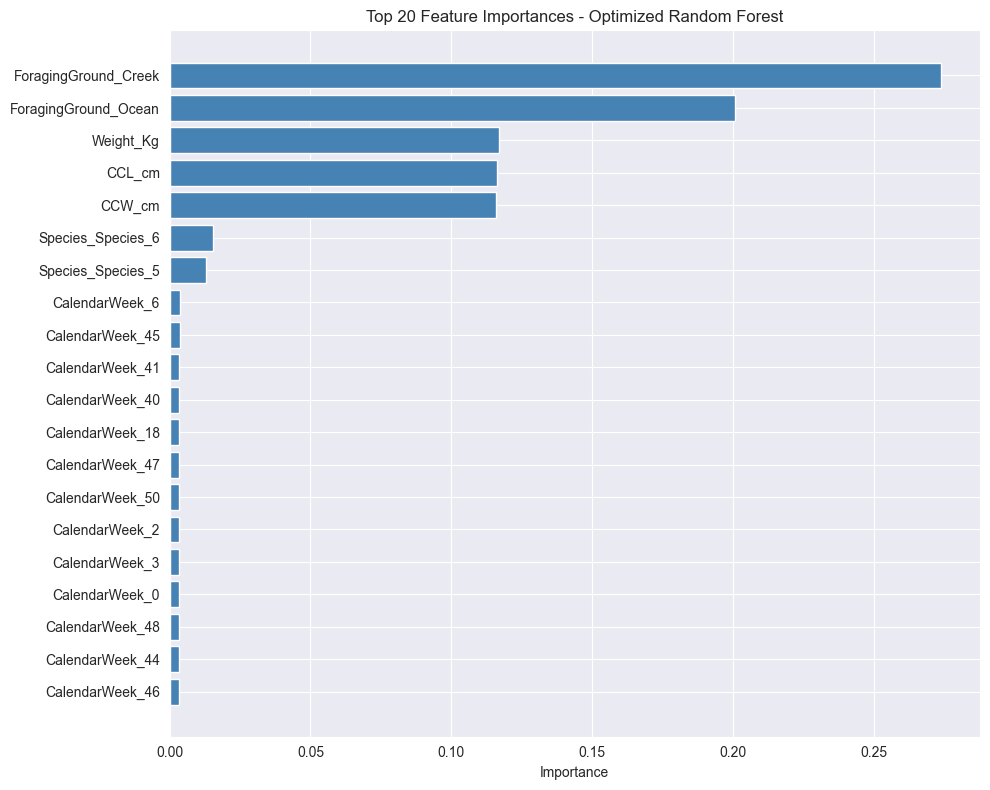

In [29]:
top_n = 20
top_features_alt = rf_feature_importances_df_alt.head(top_n).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_features_alt['feature'], top_features_alt['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Optimized Random Forest')
plt.tight_layout()
plt.show()